# Enhanced Ordinal Logistic Model Plotting

This notebook extends the Granger causality analysis with enhanced plotting capabilities that show both full and restricted ordinal logistic models with their predictions against actual data, including both unthresholded and thresholded comparisons with MAE and RMSE metrics.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
from statsmodels.miscmodels.ordinal_model import OrderedModel
from scipy.stats import chi2
from math import sqrt

## Utility Functions

These functions are copied from the original Granger.ipynb for consistency.

In [22]:
def add_time_features(dfh: pd.DataFrame) -> pd.DataFrame:
    """Add diurnal sin/cos based on the DateTimeIndex (hour + minute)."""
    h = dfh.index.hour + dfh.index.minute / 60.0
    dfh = dfh.copy()
    dfh["hour_sin"] = np.sin(2 * np.pi * h / 24)
    dfh["hour_cos"] = np.cos(2 * np.pi * h / 24)
    
    # Add day of year features
    d = dfh.index.dayofyear
    dfh["day_sin"] = np.sin(2 * np.pi * d / 365)
    dfh["day_cos"] = np.cos(2 * np.pi * d / 365)
    
    return dfh


def zscore(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """Z-score specified columns."""
    df = df.copy()
    for c in cols:
        df[f"{c}_z"] = (df[c] - df[c].mean()) / df[c].std()
    return df


def make_lags(df: pd.DataFrame, cols: List[str], L: int) -> pd.DataFrame:
    """Create lagged columns col_L1..col_LL for each col."""
    out = {}
    for c in cols:
        for l in range(1, L + 1):
            out[f"{c}_L{l}"] = df[c].shift(l)
    return pd.DataFrame(out, index=df.index)


def aic_of_fit(res) -> float:
    """Compute AIC for OrderedModel fit result."""
    k = len(res.params)
    return -2 * res.llf + 2 * k


def fit_ordered(endog: pd.Series, exog: pd.DataFrame, distr: str = "logit"):
    """
    Fit ordered logit/probit without an explicit constant (thresholds play that role).
    endog must be integer categories (0..K-1).
    """
    # Drop any rows with missing exog (endog should already be aligned)
    mask = endog.notna()
    mask &= exog.notna().all(axis=1)
    y = endog[mask].astype(int)
    X = exog.loc[mask]

    # Quick rank check to catch collinearity early (optional)
    rank = np.linalg.matrix_rank(X.values)
    if rank < X.shape[1]:
        raise ValueError(f"Design matrix not full rank (rank={rank} < {X.shape[1]}). "
                         f"Reduce lags / remove redundant columns (do not lag sin/cos).")

    model = OrderedModel(y, X, distr=distr)
    # Increase maxiter if needed; method can be 'bfgs'/'lbfgs'/'newton'
    res = model.fit(method="lbfgs", maxiter=2000, disp=False)
    return res, y.index


def lr_test(res_full, res_rest, df_restr: int) -> Tuple[float, float]:
    """LR stat and chi-square p-value."""
    LR = 2 * (res_full.llf - res_rest.llf)
    p = 1 - chi2.cdf(LR, df_restr)
    return LR, p

## Enhanced Model Fitting Function

This function fits both full and restricted models and prepares all data needed for enhanced plotting.

In [ ]:
def fit_full_and_restricted_models(data: pd.DataFrame, 
                                   gastro_col: str, 
                                   oreo_col: str, 
                                   temp_col: str, 
                                   rh_col: str,
                                   p: int = 6,
                                   s_exog: int = 6,
                                   distr: str = "logit") -> Dict:
    """
    Fit both full and restricted ordinal logistic models for both species.
    
    Returns:
        Dictionary containing full and restricted model results for both directions
    """
    
    # Prepare data
    req = [gastro_col, oreo_col, temp_col, rh_col]
    data = data.sort_index()[req].copy()
    
    # Ensure integer categories
    for c in (gastro_col, oreo_col):
        data[c] = data[c].astype(int)
    
    # Add time features and standardize weather
    data = add_time_features(data)
    data = zscore(data, [temp_col, rh_col])
    
    # Build EXOG matrix (diurnal + weather lags)
    EXOG_parts = [data[["hour_sin", "hour_cos", "day_sin", "day_cos"]]]
    for base in [temp_col + "_z", rh_col + "_z"]:
        cols_ex = {f"{base}_L0": data[base]}
        for L in range(1, s_exog + 1):
            cols_ex[f"{base}_L{L}"] = data[base].shift(L)
        EXOG_parts.append(pd.DataFrame(cols_ex, index=data.index))
    EXOG = pd.concat(EXOG_parts, axis=1)
    
    def fit_direction_models(Y_name: str, X_name: str):
        """Fit both full and restricted models for a given direction."""
        
        # Build lag matrices
        own_lags = make_lags(data, [Y_name], p)
        cross_lags = make_lags(data, [X_name], p)
        
        # Full design = own lags + cross lags + exogenous
        X_full = pd.concat([own_lags, cross_lags, EXOG], axis=1)
        
        # Restricted design = own lags + exogenous (no cross lags)
        X_rest = pd.concat([own_lags, EXOG], axis=1)
        
        endog = data[Y_name]
        
        # Fit both models
        res_full, idx_full = fit_ordered(endog, X_full, distr=distr)
        res_rest, _ = fit_ordered(endog.loc[idx_full], X_rest.loc[idx_full], distr=distr)
        
        # Generate predictions
        probs_full = res_full.predict(exog=X_full.loc[idx_full])
        probs_rest = res_rest.predict(exog=X_rest.loc[idx_full])
        
        # Get category labels and compute expected values
        cats = np.sort(endog.loc[idx_full].unique())
        exp_vals_full = (probs_full * cats).sum(axis=1)
        exp_vals_rest = (probs_rest * cats).sum(axis=1)
        
        # Compute metrics
        actual_vals = endog.loc[idx_full]
        
        # Full model metrics
        resid_full = actual_vals - exp_vals_full
        mae_full = float(np.abs(resid_full).mean())
        rmse_full = float(sqrt((resid_full**2).mean()))
        
        # Restricted model metrics
        resid_rest = actual_vals - exp_vals_rest
        mae_rest = float(np.abs(resid_rest).mean())
        rmse_rest = float(sqrt((resid_rest**2).mean()))
        
        # LR test
        LR, pval = lr_test(res_full, res_rest, p)  # p cross-lags removed
        
        return {
            'direction': f"{X_name} → {Y_name}",
            'full_model': {
                'predictions': exp_vals_full,
                'probabilities': probs_full,
                'MAE': mae_full,
                'RMSE': rmse_full,
                'AIC': aic_of_fit(res_full),
                'result': res_full
            },
            'restricted_model': {
                'predictions': exp_vals_rest,
                'probabilities': probs_rest,
                'MAE': mae_rest,
                'RMSE': rmse_rest,
                'AIC': aic_of_fit(res_rest),
                'result': res_rest
            },
            'actual_values': actual_vals,
            'index': idx_full,
            'LR_test': {'statistic': float(LR), 'p_value': float(pval), 'df': p}
        }
    
    # Fit both directions
    oreo_to_gastro = fit_direction_models(gastro_col, oreo_col)
    gastro_to_oreo = fit_direction_models(oreo_col, gastro_col)
    
    return {
        'Oreo_to_Gastro': oreo_to_gastro,
        'Gastro_to_Oreo': gastro_to_oreo,
        'settings': {
            'p': p,
            's_exog': s_exog,
            'distr': distr
        }
    }

## Enhanced Plotting Function

This function creates comprehensive plots showing both full and restricted model predictions against actual data, with both unthresholded and thresholded comparisons.

In [24]:
def create_threshold_data(data: pd.Series, threshold: float = 0.5) -> pd.Series:
    """Create thresholded version of continuous data."""
    return (data >= threshold).astype(int)


def plot_model_predictions(results: Dict, 
                          gastro_col: str = "Gastrotheca chysosticta",
                          oreo_col: str = "Oreobates berdemenos",
                          save_plot: bool = True,
                          plot_filename: str = "ordinal_model_predictions.png"):
    """
    Plot full and restricted model predictions against actual data.
    Includes both unthresholded and thresholded comparisons.
    """
    
    fig, axes = plt.subplots(4, 2, figsize=(16, 20))
    fig.suptitle('Ordinal Logistic Model Predictions: Full vs Restricted Models', fontsize=16)
    
    directions = [
        ('Oreo_to_Gastro', gastro_col, 'tab:green'),
        ('Gastro_to_Oreo', oreo_col, 'tab:orange')
    ]
    
    for col_idx, (direction_key, species_col, color) in enumerate(directions):
        direction_results = results[direction_key]
        
        actual = direction_results['actual_values']
        pred_full = direction_results['full_model']['predictions']
        pred_rest = direction_results['restricted_model']['predictions']
        idx = direction_results['index']
        
        # # Create thresholded versions (threshold at 0.5)
        # actual_thresh = create_threshold_data(actual, 0.5)
        # pred_full_thresh = create_threshold_data(pred_full, 0.5)
        # pred_rest_thresh = create_threshold_data(pred_rest, 0.5)


        # Get the thresholds from the models
        full_thresholds = direction_results['full_model'].get('thresholds', [0.5])
        rest_thresholds = direction_results['restricted_model'].get('thresholds', [0.5])

        # Apply thresholds to convert continuous predictions to ordinal categories
        def apply_ordinal_thresholds(predictions, thresholds):
                result = np.zeros_like(predictions)
                sorted_thresholds = sorted(thresholds)
                for i, threshold in enumerate(sorted_thresholds):
                        result[predictions >= threshold] = i + 1
                return result

        # Apply ordinal thresholding if available, otherwise use binary threshold
        if len(full_thresholds) > 1:
                pred_full_thresh = apply_ordinal_thresholds(pred_full, full_thresholds)
                pred_rest_thresh = apply_ordinal_thresholds(pred_rest, rest_thresholds)
        else:
                # Keep the existing binary thresholding as fallback
                pred_full_thresh = create_threshold_data(pred_full, 0.5)
                pred_rest_thresh = create_threshold_data(pred_rest, 0.5)

        # Convert actual values to the same scale if needed
        if np.max(actual) > 1:
                actual_thresh = actual.copy()
        else:
                actual_thresh = create_threshold_data(actual, 0.5)


        # Plot 1: Unthresholded actual vs full model
        ax1 = axes[0, col_idx]
        ax1.plot(idx, actual, 'k-', alpha=0.7, linewidth=0.8, label='Actual')
        ax1.plot(idx, pred_full, color=color, linewidth=1.0, label='Full Model')
        ax1.set_title(f'{direction_results["direction"]} - Full Model (Unthresholded)')
        ax1.set_ylabel('Call Count')
        ax1.legend()
        ax1.grid(alpha=0.3)
        
        # Add metrics text
        full_mae = direction_results['full_model']['MAE']
        full_rmse = direction_results['full_model']['RMSE']
        ax1.text(0.02, 0.98, f'MAE: {full_mae:.3f}\nRMSE: {full_rmse:.3f}', 
                transform=ax1.transAxes, va='top', ha='left',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Plot 2: Unthresholded actual vs restricted model
        ax2 = axes[1, col_idx]
        ax2.plot(idx, actual, 'k-', alpha=0.7, linewidth=0.8, label='Actual')
        ax2.plot(idx, pred_rest, color=color, linewidth=1.0, alpha=0.7, 
                linestyle='--', label='Restricted Model')
        ax2.set_title(f'{direction_results["direction"]} - Restricted Model (Unthresholded)')
        ax2.set_ylabel('Call Count')
        ax2.legend()
        ax2.grid(alpha=0.3)
        
        # Add metrics text
        rest_mae = direction_results['restricted_model']['MAE']
        rest_rmse = direction_results['restricted_model']['RMSE']
        ax2.text(0.02, 0.98, f'MAE: {rest_mae:.3f}\nRMSE: {rest_rmse:.3f}', 
                transform=ax2.transAxes, va='top', ha='left',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Plot 3: Thresholded actual vs full model
        ax3 = axes[2, col_idx]
        ax3.plot(idx, actual_thresh, 'k-', alpha=0.7, linewidth=0.8, label='Actual (Thresholded)')
        ax3.plot(idx, pred_full_thresh, color=color, linewidth=1.0, label='Full Model (Thresholded)')
        ax3.set_title(f'{direction_results["direction"]} - Full Model (Thresholded at 0.5)')
        ax3.set_ylabel('Binary Calls (0/1)')
        ax3.legend()
        ax3.grid(alpha=0.3)
        
        # Compute binary metrics
        full_mae_thresh = float(np.abs(actual_thresh - pred_full_thresh).mean())
        full_rmse_thresh = float(sqrt(((actual_thresh - pred_full_thresh)**2).mean()))
        ax3.text(0.02, 0.98, f'MAE: {full_mae_thresh:.3f}\nRMSE: {full_rmse_thresh:.3f}', 
                transform=ax3.transAxes, va='top', ha='left',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Plot 4: Thresholded actual vs restricted model
        ax4 = axes[3, col_idx]
        ax4.plot(idx, actual_thresh, 'k-', alpha=0.7, linewidth=0.8, label='Actual (Thresholded)')
        ax4.plot(idx, pred_rest_thresh, color=color, linewidth=1.0, alpha=0.7, 
                linestyle='--', label='Restricted Model (Thresholded)')
        ax4.set_title(f'{direction_results["direction"]} - Restricted Model (Thresholded at 0.5)')
        ax4.set_ylabel('Binary Calls (0/1)')
        ax4.set_xlabel('Time')
        ax4.legend()
        ax4.grid(alpha=0.3)
        
        # Compute binary metrics
        rest_mae_thresh = float(np.abs(actual_thresh - pred_rest_thresh).mean())
        rest_rmse_thresh = float(sqrt(((actual_thresh - pred_rest_thresh)**2).mean()))
        ax4.text(0.02, 0.98, f'MAE: {rest_mae_thresh:.3f}\nRMSE: {rest_rmse_thresh:.3f}', 
                transform=ax4.transAxes, va='top', ha='left',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    if save_plot:
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved as {plot_filename}")
    
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("MODEL COMPARISON SUMMARY")
    print("="*80)
    
    for direction_key in ['Oreo_to_Gastro', 'Gastro_to_Oreo']:
        result = results[direction_key]
        print(f"\n{result['direction']}:")
        print(f"  Full Model    - MAE: {result['full_model']['MAE']:.4f}, RMSE: {result['full_model']['RMSE']:.4f}, AIC: {result['full_model']['AIC']:.2f}")
        print(f"  Restricted Model - MAE: {result['restricted_model']['MAE']:.4f}, RMSE: {result['restricted_model']['RMSE']:.4f}, AIC: {result['restricted_model']['AIC']:.2f}")
        print(f"  LR Test: χ²={result['LR_test']['statistic']:.3f}, p={result['LR_test']['p_value']:.4f}, df={result['LR_test']['df']}")
        
        # Determine which model is better
        full_aic = result['full_model']['AIC']
        rest_aic = result['restricted_model']['AIC']
        better_model = "Full" if full_aic < rest_aic else "Restricted"
        print(f"  Better Model by AIC: {better_model}")

## Usage Example

Here's how to use the enhanced plotting functionality with your existing data:

In [25]:
PT_drive = '/Users/ash/Library/CloudStorage/OneDrive-Nexus365/PHD/arunan/Martin_google_drive'
df = pd.read_csv(f'{PT_drive}/df_helechos_clean.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df = df.set_index('DateTime').sort_index()
df.head()


,Date,Month,Day,hour,Temp,RH%,Gastrotheca chysosticta,Oreobates berdemenos
DateTime,,,,,,,,
2018-09-02 00:00:00,2018-09-02,9,245,0,4.553,100.0,0,0
2018-09-02 01:00:00,2018-09-02,9,245,1,4.051,100.0,0,0
2018-09-02 02:00:00,2018-09-02,9,245,2,4.553,100.0,0,0
2018-09-02 03:00:00,2018-09-02,9,245,3,3.550,100.0,0,0
2018-09-02 04:00:00,2018-09-02,9,245,4,3.048,100.0,0,0


In [26]:
# Example usage - replace 'df' with your actual DataFrame from Granger.ipynb
# Assuming you have already loaded your data as 'df' and run the granger analysis:
lag = 11
results_enhanced = fit_full_and_restricted_models(
    data=df,
    gastro_col="Gastrotheca chysosticta",
    oreo_col="Oreobates berdemenos", 
    temp_col="Temp",
    rh_col="RH%",
    p=lag,  # Use the selected p from your granger analysis
    s_exog=6,  # Weather lag span
    distr="logit"
)


Plot saved as lag_11_ordinal_model_predictions.png


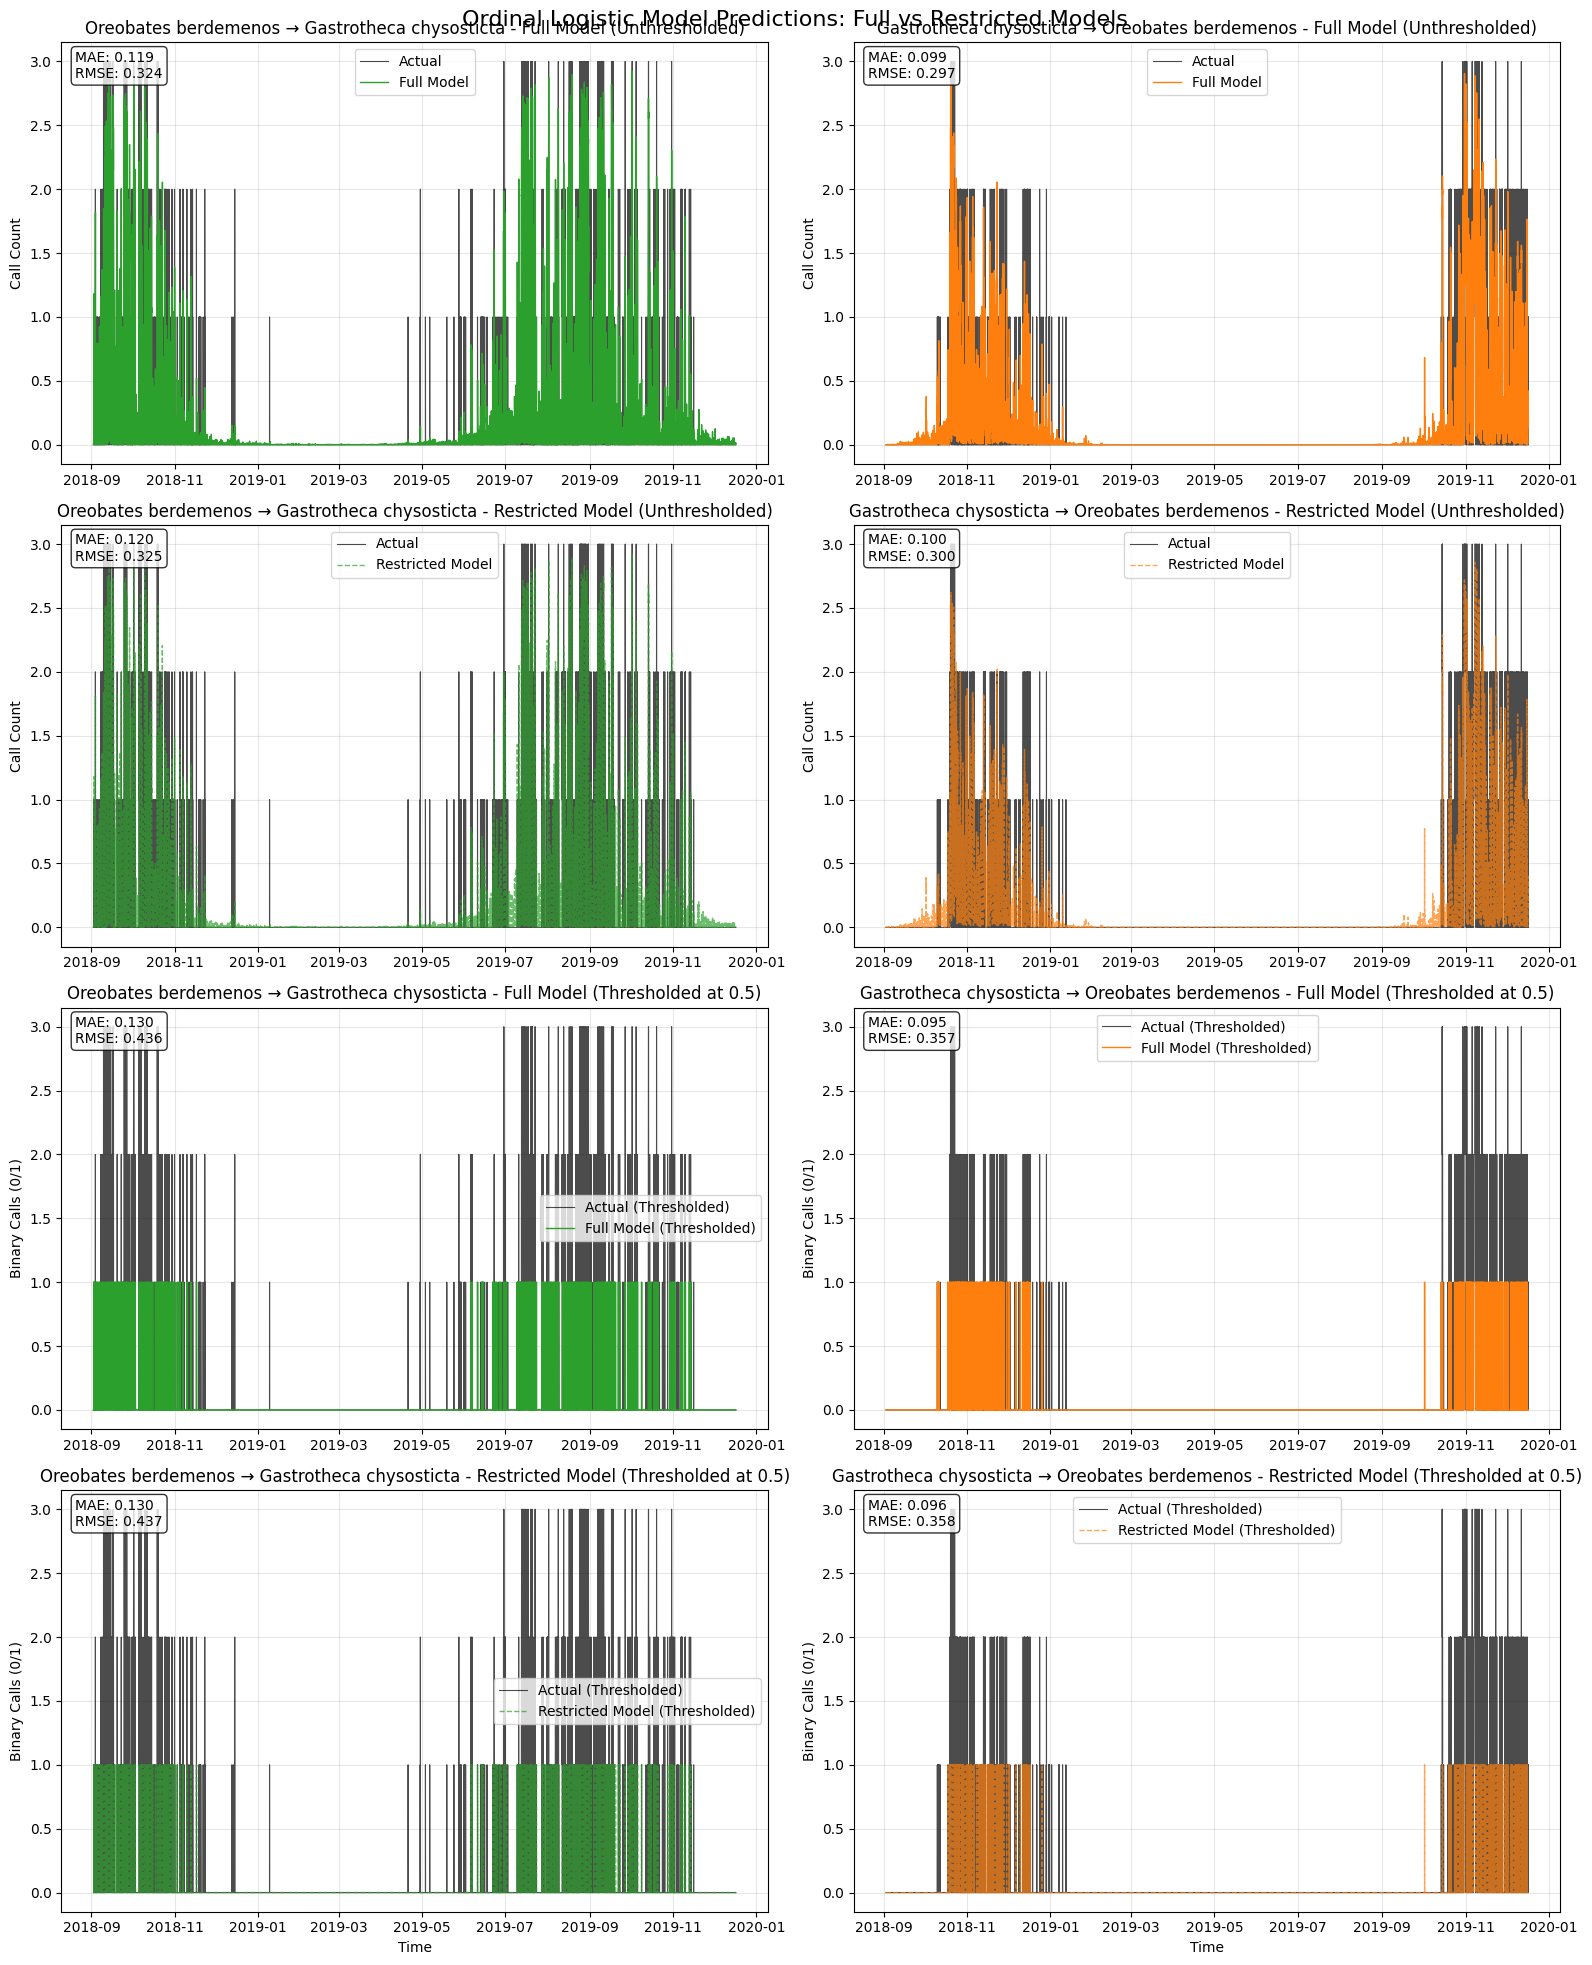


MODEL COMPARISON SUMMARY

Oreobates berdemenos → Gastrotheca chysosticta:
  Full Model    - MAE: 0.1195, RMSE: 0.3239, AIC: 4499.38
  Restricted Model - MAE: 0.1200, RMSE: 0.3247, AIC: 4498.24
  LR Test: χ²=20.865, p=0.0348, df=11
  Better Model by AIC: Restricted

Gastrotheca chysosticta → Oreobates berdemenos:
  Full Model    - MAE: 0.0988, RMSE: 0.2968, AIC: 3534.55
  Restricted Model - MAE: 0.1005, RMSE: 0.2997, AIC: 3564.27
  LR Test: χ²=51.717, p=0.0000, df=11
  Better Model by AIC: Full


In [27]:

plot_model_predictions(
    results=results_enhanced,
    save_plot=True,
    plot_filename=f"lag_{lag}_ordinal_model_predictions.png"
)

## Key Features

This enhanced plotting system provides:

1. **Full vs Restricted Model Comparison**: Shows predictions from both the full model (including cross-species lags) and restricted model (only own lags + exogenous variables)

2. **Unthresholded vs Thresholded Data**: 
   - Unthresholded: Shows continuous predicted values vs actual discrete counts
   - Thresholded: Converts predictions to binary (0/1) using a 0.5 threshold for comparison

3. **Comprehensive Metrics**: 
   - MAE (Mean Absolute Error)
   - RMSE (Root Mean Square Error) 
   - AIC for model comparison
   - Likelihood Ratio test statistics

4. **Statistical Testing**: Includes LR tests to determine if the cross-species effects are statistically significant

5. **Model Selection Guidance**: Indicates which model performs better based on AIC

The plots help visualize:
- How well each model captures the temporal patterns in the data
- Whether including cross-species interactions improves prediction accuracy
- The trade-off between model complexity and predictive performance